In the book, there is discussion on Trend labelingn based on returns, which can be sampled based on:
- Price at certain time => heteroskedastic
- Price per tick
- Price per Volume
- Price per dollar bars

We can also apply the labeling based on the standardized return (adjusted for volatility)

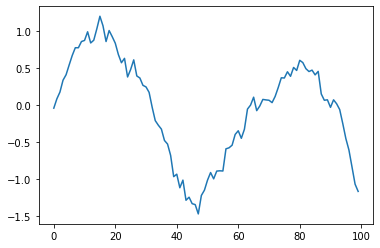

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
df0= pd.Series(np.random.normal(0, .1, 100).cumsum())
df0 += np.sin(np.linspace(0,10, df0.shape[0]))
df0.plot()

In [2]:
import statsmodels.api as sml
def tValLinR(close):
    # tValue from a linear trend
    # ie: just one value
    x = np.ones((close.shape[0], 2))
    x[:, 1] =np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

tValLinR(df0)

-3.3207245509892185

In [3]:
x = np.ones((df0.shape[0], 2))
x[:, 1] = np.arange(df0.shape[0])
x[:5,:]

array([[1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

In [4]:
# Trend scanning method
def getBinsFromTrend(molecule, close, span):
    """
    Derive labels from the sign of t-value of the linear trend
    input:
    - molecule: index of observations we wish to label
    - close: time of series of {x_t}
    - span = set of values of horizon that the algorithm will use
    Output :
    - t1: End time for the identified trend
    - tval: t-value associated with the estimated trend coefficient
    - bin: Sign of the trend
    """
    out = pd.DataFrame(index=molecule, columns=['t1', 'tVal','bin','horizon'])
    horizons = range(*span)
    
    for dt0 in molecule:
        df0=pd.Series(dtype=float)
        horizon_list=pd.Series(dtype=int)
        
        # get the integer location of this label
        iloc0=close.index.get_loc(dt0)
        
        if iloc0+max(horizons) > close.shape[0]:continue # if it is out of range
        
        for hrzn in horizons:
            # loop through possible horizon value
            dt1 = close.index[iloc0+hrzn-1] # the indices
            df1 = close.loc[dt0:dt1] # the values according to the indices
            # get the tvalues of this horizon (which is quite short)
            df0.loc[dt1] = tValLinR(df1.values) 
            horizon_list.loc[dt1] = hrzn
        
        # Replace NaN and get the index of the max
        selected_index = df0.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
        
        # df0.index[-1] is the last value of the index
        # so this is all the end till the end of the trend
        out.loc[dt0, ['t1','tVal','bin','horizon']] = df0.index[-1], df0[selected_index], np.sign(df0[selected_index]), horizon_list[selected_index] # prevent leakage???
        
    # out['t1'] = pd.to_datetime(out['t1'])
    out['bin'] = pd.to_numeric(out['bin'], downcast = 'signed')
    out['horizon']=out['horizon'].fillna(0.0).astype(int)
    return out.dropna(subset=['bin'])
    

In [5]:
display(df0[:5])
display(df0[-5:])

0   -0.042521
1    0.083369
2    0.175209
3    0.335402
4    0.409990
dtype: float64

95   -0.454307
96   -0.609081
97   -0.838874
98   -1.071223
99   -1.169241
dtype: float64

## Notice that some indices don't get a label 
by design, each molecule (date) get the farthest value of the horizon

In [6]:
print(max(range(3,10,1)),df0.index[8])

9 8


## it appears to be quite a time consuming function

In [7]:
df1 = getBinsFromTrend(df0.index, df0, [3,10,1])
display(df1.head())
display(df1.tail())

,t1,tVal,bin,horizon
0,8,49.5205,1.0,8
1,9,36.8914,1.0,7
2,10,27.1824,1.0,6
3,11,20.6859,1.0,5
4,12,118.405,1.0,3


,t1,tVal,bin,horizon
87,95,-4.40198,-1.0,9
88,96,-4.92461,-1.0,9
89,97,-6.36834,-1.0,9
90,98,-8.11723,-1.0,9
91,99,-18.3795,-1.0,9


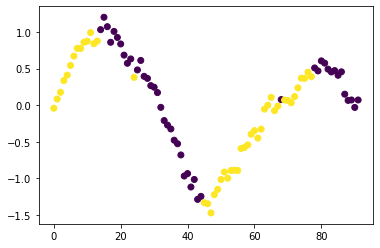

In [8]:
plt.scatter(df1.index, df0.loc[df1.index].values,
           c=df1['bin'].values, cmap='viridis')

In [9]:
df0[:5]

0   -0.042521
1    0.083369
2    0.175209
3    0.335402
4    0.409990
dtype: float64

In [10]:
df = pd.DataFrame(df0,columns=['val'])
df = df.merge(df1, left_index=True,right_on='t1',how='left')
df.head(10)

,val,t1,tVal,bin,horizon
NaN,-0.042521,0,NaN,NaN,NaN
NaN,0.083369,1,NaN,NaN,NaN
NaN,0.175209,2,NaN,NaN,NaN
NaN,0.335402,3,NaN,NaN,NaN
NaN,0.409990,4,NaN,NaN,NaN
NaN,0.542132,5,NaN,NaN,NaN
NaN,0.670463,6,NaN,NaN,NaN
NaN,0.775134,7,NaN,NaN,NaN
0.0,0.774858,8,49.5205,1.0,8.0
1.0,0.858866,9,36.8914,1.0,7.0


In [11]:
df = df.reset_index(drop=True)
df['bin'] = df['bin'].fillna(0.0).astype(int)
df.head(10)

,val,t1,tVal,bin,horizon
0,-0.042521,0,NaN,0,NaN
1,0.083369,1,NaN,0,NaN
2,0.175209,2,NaN,0,NaN
3,0.335402,3,NaN,0,NaN
4,0.409990,4,NaN,0,NaN
5,0.542132,5,NaN,0,NaN
6,0.670463,6,NaN,0,NaN
7,0.775134,7,NaN,0,NaN
8,0.774858,8,49.5205,1,8.0
9,0.858866,9,36.8914,1,7.0


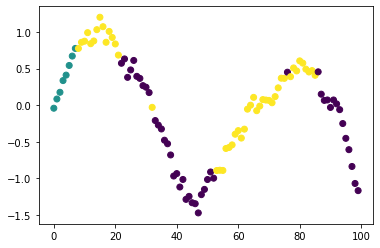

In [12]:
# color by labels
plt.scatter(df.t1, df.val.values,
           c=df['bin'].values, cmap='viridis')